**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [82]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 500
h2_dim=250
z_dim = 2
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=500,h2_dim=250, z_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, z_dim)
        self.fc4 = nn.Linear(h2_dim,z_dim)
        self.fc5 = nn.Linear(z_dim, h2_dim)
        self.fc6 = nn.Linear(h2_dim, h_dim)
        self.fc7 = nn.Linear(h_dim,image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h), self.fc4(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        return F.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 38149.5664, KL Div: 482.2901
Epoch[1/15], Step [20/469], Reconst Loss: 28411.6855, KL Div: 54.7984
Epoch[1/15], Step [30/469], Reconst Loss: 27232.2383, KL Div: 49.7015
Epoch[1/15], Step [40/469], Reconst Loss: 25675.3203, KL Div: 175.9017
Epoch[1/15], Step [50/469], Reconst Loss: 25827.8203, KL Div: 198.8885
Epoch[1/15], Step [60/469], Reconst Loss: 25730.8125, KL Div: 279.4591
Epoch[1/15], Step [70/469], Reconst Loss: 24352.6387, KL Div: 323.6349
Epoch[1/15], Step [80/469], Reconst Loss: 24166.5039, KL Div: 277.4374
Epoch[1/15], Step [90/469], Reconst Loss: 24668.9453, KL Div: 312.2752
Epoch[1/15], Step [100/469], Reconst Loss: 23942.2109, KL Div: 331.5440
Epoch[1/15], Step [110/469], Reconst Loss: 22505.0566, KL Div: 419.5995
Epoch[1/15], Step [120/469], Reconst Loss: 23324.0176, KL Div: 475.1571
Epoch[1/15], Step [130/469], Reconst Loss: 22783.9941, KL Div: 461.8740
Epoch[1/15], Step [140/469], Reconst Loss: 23499.3613, KL Div: 513.7986
Epo

Epoch[3/15], Step [240/469], Reconst Loss: 18782.0176, KL Div: 750.7610
Epoch[3/15], Step [250/469], Reconst Loss: 17688.4355, KL Div: 711.9367
Epoch[3/15], Step [260/469], Reconst Loss: 19454.8457, KL Div: 765.2628
Epoch[3/15], Step [270/469], Reconst Loss: 20031.4102, KL Div: 726.2435
Epoch[3/15], Step [280/469], Reconst Loss: 18839.3711, KL Div: 721.4814
Epoch[3/15], Step [290/469], Reconst Loss: 19142.3203, KL Div: 709.8536
Epoch[3/15], Step [300/469], Reconst Loss: 18790.6875, KL Div: 729.5415
Epoch[3/15], Step [310/469], Reconst Loss: 18714.8066, KL Div: 755.7217
Epoch[3/15], Step [320/469], Reconst Loss: 19719.5996, KL Div: 714.4269
Epoch[3/15], Step [330/469], Reconst Loss: 19326.5234, KL Div: 705.5738
Epoch[3/15], Step [340/469], Reconst Loss: 18597.7070, KL Div: 725.3961
Epoch[3/15], Step [350/469], Reconst Loss: 19186.0938, KL Div: 729.2775
Epoch[3/15], Step [360/469], Reconst Loss: 19139.8828, KL Div: 746.7068
Epoch[3/15], Step [370/469], Reconst Loss: 18202.0078, KL Div: 7

Epoch[6/15], Step [10/469], Reconst Loss: 17996.4961, KL Div: 733.4492
Epoch[6/15], Step [20/469], Reconst Loss: 18690.1582, KL Div: 785.3301
Epoch[6/15], Step [30/469], Reconst Loss: 17847.0742, KL Div: 801.5296
Epoch[6/15], Step [40/469], Reconst Loss: 18125.5215, KL Div: 749.1318
Epoch[6/15], Step [50/469], Reconst Loss: 18130.1992, KL Div: 784.5012
Epoch[6/15], Step [60/469], Reconst Loss: 18034.1035, KL Div: 804.7885
Epoch[6/15], Step [70/469], Reconst Loss: 18727.9238, KL Div: 824.5031
Epoch[6/15], Step [80/469], Reconst Loss: 17751.6602, KL Div: 788.2051
Epoch[6/15], Step [90/469], Reconst Loss: 18186.1406, KL Div: 792.8186
Epoch[6/15], Step [100/469], Reconst Loss: 18250.2246, KL Div: 758.9377
Epoch[6/15], Step [110/469], Reconst Loss: 17852.0820, KL Div: 810.2943
Epoch[6/15], Step [120/469], Reconst Loss: 18418.0977, KL Div: 789.4643
Epoch[6/15], Step [130/469], Reconst Loss: 17408.9375, KL Div: 778.0391
Epoch[6/15], Step [140/469], Reconst Loss: 18669.3789, KL Div: 818.5981
E

Epoch[8/15], Step [240/469], Reconst Loss: 18312.1367, KL Div: 794.1882
Epoch[8/15], Step [250/469], Reconst Loss: 18647.0898, KL Div: 797.4795
Epoch[8/15], Step [260/469], Reconst Loss: 17369.3809, KL Div: 786.7710
Epoch[8/15], Step [270/469], Reconst Loss: 17481.4531, KL Div: 782.8282
Epoch[8/15], Step [280/469], Reconst Loss: 17057.7461, KL Div: 799.6334
Epoch[8/15], Step [290/469], Reconst Loss: 20011.0625, KL Div: 752.4141
Epoch[8/15], Step [300/469], Reconst Loss: 17741.7480, KL Div: 765.2941
Epoch[8/15], Step [310/469], Reconst Loss: 17341.9355, KL Div: 816.1481
Epoch[8/15], Step [320/469], Reconst Loss: 17957.8438, KL Div: 795.9727
Epoch[8/15], Step [330/469], Reconst Loss: 17598.9648, KL Div: 799.2238
Epoch[8/15], Step [340/469], Reconst Loss: 18054.8887, KL Div: 835.1868
Epoch[8/15], Step [350/469], Reconst Loss: 18235.3652, KL Div: 755.0657
Epoch[8/15], Step [360/469], Reconst Loss: 18245.9395, KL Div: 794.3519
Epoch[8/15], Step [370/469], Reconst Loss: 17949.8516, KL Div: 7

Epoch[10/15], Step [460/469], Reconst Loss: 18526.5996, KL Div: 843.8774
Epoch[11/15], Step [10/469], Reconst Loss: 17075.9648, KL Div: 850.0528
Epoch[11/15], Step [20/469], Reconst Loss: 17335.2461, KL Div: 842.6107
Epoch[11/15], Step [30/469], Reconst Loss: 16777.2676, KL Div: 807.4547
Epoch[11/15], Step [40/469], Reconst Loss: 17263.4727, KL Div: 818.4871
Epoch[11/15], Step [50/469], Reconst Loss: 16521.4375, KL Div: 850.0097
Epoch[11/15], Step [60/469], Reconst Loss: 18103.9160, KL Div: 806.9241
Epoch[11/15], Step [70/469], Reconst Loss: 17539.8066, KL Div: 818.8981
Epoch[11/15], Step [80/469], Reconst Loss: 18560.7285, KL Div: 817.5990
Epoch[11/15], Step [90/469], Reconst Loss: 16736.1113, KL Div: 841.1550
Epoch[11/15], Step [100/469], Reconst Loss: 17504.6895, KL Div: 839.5943
Epoch[11/15], Step [110/469], Reconst Loss: 16975.4844, KL Div: 827.9739
Epoch[11/15], Step [120/469], Reconst Loss: 16735.3555, KL Div: 811.1173
Epoch[11/15], Step [130/469], Reconst Loss: 18008.5859, KL D

Epoch[13/15], Step [210/469], Reconst Loss: 17022.7344, KL Div: 870.6978
Epoch[13/15], Step [220/469], Reconst Loss: 17243.4531, KL Div: 812.8289
Epoch[13/15], Step [230/469], Reconst Loss: 16796.9805, KL Div: 867.4174
Epoch[13/15], Step [240/469], Reconst Loss: 18150.2383, KL Div: 815.0635
Epoch[13/15], Step [250/469], Reconst Loss: 17403.4980, KL Div: 820.6459
Epoch[13/15], Step [260/469], Reconst Loss: 16475.1719, KL Div: 842.8940
Epoch[13/15], Step [270/469], Reconst Loss: 17051.6465, KL Div: 816.3104
Epoch[13/15], Step [280/469], Reconst Loss: 16906.7891, KL Div: 812.3554
Epoch[13/15], Step [290/469], Reconst Loss: 17186.6289, KL Div: 824.9982
Epoch[13/15], Step [300/469], Reconst Loss: 15821.4043, KL Div: 821.1373
Epoch[13/15], Step [310/469], Reconst Loss: 17629.5879, KL Div: 867.8630
Epoch[13/15], Step [320/469], Reconst Loss: 16804.6758, KL Div: 812.4562
Epoch[13/15], Step [330/469], Reconst Loss: 17614.7012, KL Div: 810.3826
Epoch[13/15], Step [340/469], Reconst Loss: 18430.3

Epoch[15/15], Step [420/469], Reconst Loss: 17576.7656, KL Div: 837.4358
Epoch[15/15], Step [430/469], Reconst Loss: 17616.8086, KL Div: 852.6957
Epoch[15/15], Step [440/469], Reconst Loss: 16000.9971, KL Div: 809.2606
Epoch[15/15], Step [450/469], Reconst Loss: 16806.3359, KL Div: 829.0476
Epoch[15/15], Step [460/469], Reconst Loss: 17076.4746, KL Div: 878.7231


torch.Size([1, 1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

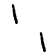

In [89]:
test_data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          shuffle=True)
(varient,_)=next(iter(test_data_loader))
print(varient.shape)
varient2=varient.squeeze(dim=0)
x=varient
x=x.view(-1, image_size)
print(x.shape)
print(varient2.shape)
print(varient2)
new_tensor=torch.zeros([1,56,56])
new_tensor[0,0:28,0:28]=varient2
new_tensor[0,28:56,28:56]=varient2
new_tensor=1-new_tensor
t2 = transforms.ToPILImage()
new_image = t2(new_tensor)
new_image

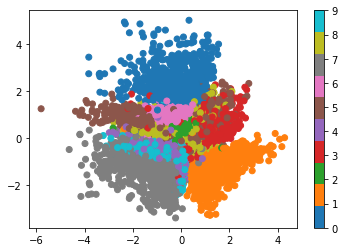

In [83]:
from matplotlib import pyplot as plt
test_data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10000,
                                          shuffle=True)
(x,y)=next(iter(test_data_loader))
x=x.view(-1, image_size)

mu, log_var = model.encode(x)
z = model.reparameterize(mu, log_var)
z = z.detach().numpy()
plt.scatter(z[:, 0], z[:, 1],c=y, cmap='tab10')
#mu=mu.detach().numpy()
#log_var=log_var.detach().numpy()
#plt.scatter(mu[:, 0], log_var[:, 0],c=y, cmap='tab10')
plt.colorbar()

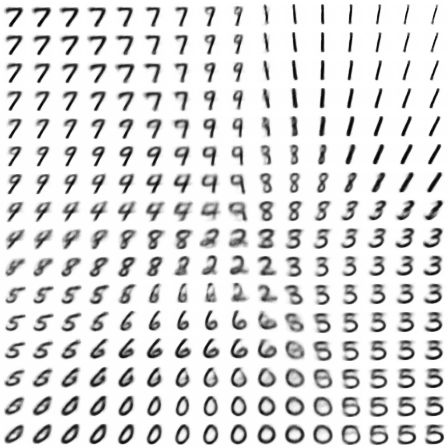

In [100]:
import numpy as np
values = np.arange(-2, 2, .26)
xx, yy = np.meshgrid(values, values)
new_tensor=torch.zeros([1,28*len(values),28*len(values)])
t2 = transforms.ToPILImage()
z=torch.zeros([1,1,2])


for row in range(xx.shape[0]):
    for col in range(xx.shape[1]):
        z[0,0,0]=xx[row, col]
        z[0,0,1]=yy[row, col]
        temp=torch.reshape(model.decode(z),[1,28,28])
        temp[temp<0]=0
        temp[temp>1]=1
        new_tensor[0,row*28:(row+1)*28,col*28:(col+1)*28]=temp


        
new_tensor=1-new_tensor      
new_image = t2(new_tensor)
new_image